<a href="https://colab.research.google.com/github/Powertrend/mvp_brasileirao_2024/blob/main/MVP_Fut_2024_Pred_Vit_Emp_Der.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Engenharia de Sistemas de Software Inteligentes
## Predição de Vitória, Empate, Derrota Brasileirão 2024

In [12]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e modelagem
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Modelos de classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier

# Balanceamento de classes
from imblearn.over_sampling import SMOTE
# Hiperparâmetros
# from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Serialização dos objetos
import joblib

# Download dos objetos
from google.colab import files

# Ignorar avisos
import warnings
warnings.filterwarnings("ignore")


Carregamento dos DataSets

In [13]:
# Carregando os datasets
url_classificacao = "https://raw.githubusercontent.com/Powertrend/mvp_brasileirao_2024/main/dataset/Classificacao.csv"
url_partidas_realizadas = "https://raw.githubusercontent.com/Powertrend/mvp_brasileirao_2024/main/dataset/Partidas_Realizadas.csv"
url_partidas_nao_realizadas = "https://raw.githubusercontent.com/Powertrend/mvp_brasileirao_2024/main/dataset/Partidas_Nao_Realizadas.csv"

df_classificacao = pd.read_csv(url_classificacao, delimiter=',')
df_partidas_realizadas = pd.read_csv(url_partidas_realizadas, delimiter=',')
df_partidas_nao_realizadas = pd.read_csv(url_partidas_nao_realizadas, delimiter=',')

# Visualizando as primeiras linhas de cada dataset
print("Classificação:")
display(df_classificacao.head())

print("\nPartidas Realizadas:")
display(df_partidas_realizadas.head())

print("\nPartidas Não Realizadas:")
display(df_partidas_nao_realizadas.head())


Classificação:


,Rodada,Time,Posicao,Pontos,Jogos,Vitorias,Empates,Derrotas,GP,GC,SG
0,24,Fortaleza,1,48,23,14,6,3,30,20,10
1,24,Botafogo,2,47,24,14,5,5,41,24,17
2,24,Palmeiras,3,44,24,13,5,6,36,19,17
3,24,Flamengo,4,44,23,13,5,5,38,26,12
4,24,São Paulo,5,41,24,12,5,7,33,24,9



Partidas Realizadas:


,Rodada,Mandante,Placar_Mandante,Placar_Visitante,Visitante,Estadio,Data,Dia,Hora
0,1,Vitória,0,1,Palmeiras,Barradão,14/04,Domingo,18:30
1,1,Internacional,2,1,Bahia,Beira-Rio,13/04,Sábado,18:30
2,1,Criciúma,1,1,Juventude,Heriberto Hülse,13/04,Sábado,18:30
3,1,Fluminense,2,2,Bragantino,Maracanã,13/04,Sábado,21:00
4,1,São Paulo,1,2,Fortaleza,Morumbis,13/04,Sábado,21:00



Partidas Não Realizadas:


,Rodada,Mandante,Visitante,Data
0,25,Cuiabá,Criciúma,31/08
1,25,Botafogo,Fortaleza,31/08
2,25,Cruzeiro,Atlético-GO,01/09
3,25,Grêmio,Atlético-MG,01/09
4,25,Corinthians,Flamengo,01/09


1. Previsão do Resultado da Partida (Vitória Mandante, Empate, Vitória Visitante)

Análise e pré-processamento dos dados

Focar inicialmente no dataset Partidas_Realizadas.csv.

In [14]:
# Verificando informações do dataset
df_partidas_realizadas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Rodada            240 non-null    int64 
 1   Mandante          240 non-null    object
 2   Placar_Mandante   240 non-null    object
 3   Placar_Visitante  240 non-null    object
 4   Visitante         240 non-null    object
 5   Estadio           240 non-null    object
 6   Data              231 non-null    object
 7   Dia               232 non-null    object
 8   Hora              232 non-null    object
dtypes: int64(1), object(8)
memory usage: 17.0+ KB


Criando a variável alvo (resultado da partida)
Vamos criar uma coluna que represente o resultado da partida:

Vitória Mandante

Empate

Vitória Visitante

In [21]:
from sklearn.preprocessing import LabelEncoder

# Função para determinar o resultado do jogo
def determinar_resultado(row):
    if row['Placar_Mandante'] > row['Placar_Visitante']:
        return 'Vitoria_Mandante'
    elif row['Placar_Mandante'] < row['Placar_Visitante']:
        return 'Vitoria_Visitante'
    else:
        return 'Empate'

# Obter a classificação da última rodada
def obter_classificacao_ultima_rodada(df_classificacao):
    df_classificacao['Time'] = df_classificacao['Time'].str.strip().str.lower()
    ultima_rodada = df_classificacao['Rodada'].max()
    df_classificacao_ultima_rodada = df_classificacao[df_classificacao['Rodada'] == ultima_rodada]
    df_classificacao_ultima_rodada = df_classificacao_ultima_rodada.set_index('Time')
    return df_classificacao_ultima_rodada

# Função para buscar a posição na última rodada
def obter_posicao(time, df_classificacao_ultima_rodada):
    time = time.strip().lower()
    if time in df_classificacao_ultima_rodada.index:
        return df_classificacao_ultima_rodada.loc[time, 'Posicao']
    else:
        return -1

# Função para preparar os datasets
def preparar_datasets(df_partidas_realizadas, df_partidas_nao_realizadas, df_classificacao):
    # Calcular a tabela da última rodada uma única vez
    df_classificacao_ultima_rodada = obter_classificacao_ultima_rodada(df_classificacao)

    # Aplicar as transformações nos dados de partidas realizadas
    df_partidas_realizadas['Resultado'] = df_partidas_realizadas.apply(determinar_resultado, axis=1)
    df_partidas_realizadas['Posicao_Mandante'] = df_partidas_realizadas['Mandante'].apply(lambda x: obter_posicao(x, df_classificacao_ultima_rodada))
    df_partidas_realizadas['Posicao_Visitante'] = df_partidas_realizadas['Visitante'].apply(lambda x: obter_posicao(x, df_classificacao_ultima_rodada))

    # Criando a feature de diferença de posição
    df_partidas_realizadas['Diferenca_Posicao'] = df_partidas_realizadas['Posicao_Mandante'] - df_partidas_realizadas['Posicao_Visitante']

    # Aplicar as mesmas transformações para partidas não realizadas
    df_partidas_nao_realizadas['Posicao_Mandante'] = df_partidas_nao_realizadas['Mandante'].apply(lambda x: obter_posicao(x, df_classificacao_ultima_rodada))
    df_partidas_nao_realizadas['Posicao_Visitante'] = df_partidas_nao_realizadas['Visitante'].apply(lambda x: obter_posicao(x, df_classificacao_ultima_rodada))
    df_partidas_nao_realizadas['Diferenca_Posicao'] = df_partidas_nao_realizadas['Posicao_Mandante'] - df_partidas_nao_realizadas['Posicao_Visitante']

    return df_partidas_realizadas, df_partidas_nao_realizadas, df_classificacao_ultima_rodada

# Preparando os datasets
df_partidas_realizadas, df_partidas_nao_realizadas, df_classificacao_ultima_rodada = preparar_datasets(df_partidas_realizadas, df_partidas_nao_realizadas, df_classificacao)

# Codificando os times (Mandante e Visitante)
label_encoder = LabelEncoder()
df_partidas_realizadas['Time_Mandante_Cod'] = label_encoder.fit_transform(df_partidas_realizadas['Mandante'])
df_partidas_realizadas['Time_Visitante_Cod'] = label_encoder.transform(df_partidas_realizadas['Visitante'])

# Codificando as posições
posicao_encoder = LabelEncoder()
df_partidas_realizadas['Posicao_Mandante_Cod'] = posicao_encoder.fit_transform(df_partidas_realizadas['Posicao_Mandante'])
df_partidas_realizadas['Posicao_Visitante_Cod'] = posicao_encoder.transform(df_partidas_realizadas['Posicao_Visitante'])

# Codificando o resultado
resultado_encoder = LabelEncoder()
df_partidas_realizadas['Resultado_Cod'] = resultado_encoder.fit_transform(df_partidas_realizadas['Resultado'])

# Visualizando as classes codificadas do resultado
print("Classes de Resultado:", resultado_encoder.classes_)

# Visualizando o dataframe após as transformações
print(df_partidas_realizadas[['Mandante', 'Visitante', 'Resultado', 'Posicao_Mandante', 'Posicao_Visitante', 'Diferenca_Posicao', 'Resultado_Cod']])

# Definindo as features e o alvo para o modelo
X_realizadas = df_partidas_realizadas[['Time_Mandante_Cod', 'Time_Visitante_Cod', 'Posicao_Mandante_Cod', 'Posicao_Visitante_Cod', 'Diferenca_Posicao']]
y_realizadas = df_partidas_realizadas['Resultado_Cod']

# Preparar o dataframe para predição
X_nao_realizadas = df_partidas_nao_realizadas[['Mandante', 'Visitante']]
X_nao_realizadas['Time_Mandante_Cod'] = label_encoder.transform(X_nao_realizadas['Mandante'])
X_nao_realizadas['Time_Visitante_Cod'] = label_encoder.transform(X_nao_realizadas['Visitante'])
X_nao_realizadas['Posicao_Mandante_Cod'] = X_nao_realizadas['Mandante'].apply(lambda x: obter_posicao(x, df_classificacao_ultima_rodada))
X_nao_realizadas['Posicao_Visitante_Cod'] = X_nao_realizadas['Visitante'].apply(lambda x: obter_posicao(x, df_classificacao_ultima_rodada))
X_nao_realizadas['Diferenca_Posicao'] = X_nao_realizadas['Posicao_Mandante_Cod'] - X_nao_realizadas['Posicao_Visitante_Cod']

# Definindo as features para o modelo
X_nao_realizadas = X_nao_realizadas[['Time_Mandante_Cod', 'Time_Visitante_Cod', 'Posicao_Mandante_Cod', 'Posicao_Visitante_Cod', 'Diferenca_Posicao']]

# Visualizando as predições
print(X_nao_realizadas)


Classes de Resultado: ['Empate' 'Vitoria_Mandante' 'Vitoria_Visitante']
          Mandante    Visitante          Resultado  Posicao_Mandante  \
0          Vitória    Palmeiras  Vitoria_Visitante                17   
1    Internacional        Bahia   Vitoria_Mandante                11   
2         Criciúma    Juventude             Empate                15   
3       Fluminense   Bragantino             Empate                16   
4        São Paulo    Fortaleza  Vitoria_Visitante                 5   
..             ...          ...                ...               ...   
235      Fortaleza  Corinthians   Vitoria_Mandante                 1   
236          Bahia     Botafogo             Empate                 6   
237    Atlético-MG   Fluminense  Vitoria_Visitante                 8   
238      Palmeiras       Cuiabá   Vitoria_Mandante                 3   
239    Atlético-GO    Juventude   Vitoria_Mandante                20   

     Posicao_Visitante  Diferenca_Posicao  Resultado_Cod  
0   

Codificando variáveis categóricas

Como temos os nomes dos times, precisamos transformá-los em valores numéricos.



In [22]:
# Codificando os times (Mandante e Visitante)
label_encoder = LabelEncoder()
posicao_encoder = LabelEncoder()

df_partidas_realizadas['Time_Mandante_Cod'] = label_encoder.fit_transform(df_partidas_realizadas['Mandante'])
df_partidas_realizadas['Time_Visitante_Cod'] = label_encoder.transform(df_partidas_realizadas['Visitante'])

# Codificando as posições
df_partidas_realizadas['Posicao_Mandante_Cod'] = posicao_encoder.fit_transform(df_partidas_realizadas['Posicao_Mandante'])
df_partidas_realizadas['Posicao_Visitante_Cod'] = posicao_encoder.transform(df_partidas_realizadas['Posicao_Visitante'])

# Codificando o resultado (sem redundância)
resultado_encoder = LabelEncoder()
df_partidas_realizadas['Resultado_Cod'] = resultado_encoder.fit_transform(df_partidas_realizadas['Resultado'])

# Criando uma feature com a diferença de posição entre mandante e visitante
df_partidas_realizadas['Diferenca_Posicao'] = df_partidas_realizadas['Posicao_Mandante'] - df_partidas_realizadas['Posicao_Visitante']

# Verificando as classes codificadas do resultado
print("Classes de Resultado:", resultado_encoder.classes_)

# Visualizando o dataframe após as transformações
print(df_partidas_realizadas[['Mandante', 'Visitante', 'Resultado', 'Posicao_Mandante', 'Posicao_Visitante', 'Diferenca_Posicao', 'Resultado_Cod']])


Classes de Resultado: ['Empate' 'Vitoria_Mandante' 'Vitoria_Visitante']
          Mandante    Visitante          Resultado  Posicao_Mandante  \
0          Vitória    Palmeiras  Vitoria_Visitante                17   
1    Internacional        Bahia   Vitoria_Mandante                11   
2         Criciúma    Juventude             Empate                15   
3       Fluminense   Bragantino             Empate                16   
4        São Paulo    Fortaleza  Vitoria_Visitante                 5   
..             ...          ...                ...               ...   
235      Fortaleza  Corinthians   Vitoria_Mandante                 1   
236          Bahia     Botafogo             Empate                 6   
237    Atlético-MG   Fluminense  Vitoria_Visitante                 8   
238      Palmeiras       Cuiabá   Vitoria_Mandante                 3   
239    Atlético-GO    Juventude   Vitoria_Mandante                20   

     Posicao_Visitante  Diferenca_Posicao  Resultado_Cod  
0   

Selecionando as features e o alvo

Vamos definir as features (X) e o alvo (y).

In [23]:
# Selecionando as features e o alvo
X = df_partidas_realizadas[['Time_Mandante_Cod', 'Time_Visitante_Cod',
                            'Posicao_Mandante_Cod', 'Posicao_Visitante_Cod',
                            'Diferenca_Posicao']]
y = df_partidas_realizadas['Resultado_Cod']

# Visualizando o dataset com as novas features
print(X.head())


   Time_Mandante_Cod  Time_Visitante_Cod  Posicao_Mandante_Cod  \
0                 19                  16                    16   
1                 14                   3                    10   
2                  7                  15                    14   
3                 11                   5                    15   
4                 17                  12                     4   

   Posicao_Visitante_Cod  Diferenca_Posicao  
0                      2                 14  
1                      5                  5  
2                     11                  3  
3                     13                  2  
4                      0                  4  


Dividindo os dados em treino e teste

In [24]:
# Dividindo em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7, stratify=y)


Padronizando os dados

In [25]:
# Padronizando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Visualizando os primeiros registros após o escalonamento
print("Primeiros registros de X_train_scaled:", X_train_scaled[:5])

Primeiros registros de X_train_scaled: [[ 0.75107369  1.30658879  0.17661751 -0.94946319  0.77549415]
 [-0.82208429  0.79005128  0.70100763  0.09124242  0.41671131]
 [ 1.45025501  0.10133461  0.0018208  -1.12291412  0.77549415]
 [ 1.10066435  1.65094712 -1.22175615  1.13194803 -1.61639141]
 [-1.52126561  0.61787212  1.74978787  0.43814429  0.89508842]]


Treinando os modelos

Vamos testar diferentes algoritmos de classificação.

In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score

# Balanceamento de classes com SMOTE
smote = SMOTE(random_state=7)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Definindo os modelos
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('Logistic Regression', LogisticRegression(max_iter=1000)))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Gradient Boosting', GradientBoostingClassifier()))

# Avaliando os modelos
results = []
names = []
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

for name, model in models:
    cv_results = cross_val_score(model, X_train_resampled, y_train_resampled, cv=kfold, scoring='f1_weighted')
    results.append(cv_results)
    names.append(name)
    print(f"{name}: Média={cv_results.mean():.3f}, Desvio Padrão={cv_results.std():.3f}")


KNN: Média=0.523, Desvio Padrão=0.070
Decision Tree: Média=0.587, Desvio Padrão=0.086
Naive Bayes: Média=0.476, Desvio Padrão=0.091
SVM: Média=0.557, Desvio Padrão=0.086
Logistic Regression: Média=0.488, Desvio Padrão=0.083
Random Forest: Média=0.620, Desvio Padrão=0.093
Gradient Boosting: Média=0.557, Desvio Padrão=0.099


Comparando os modelos

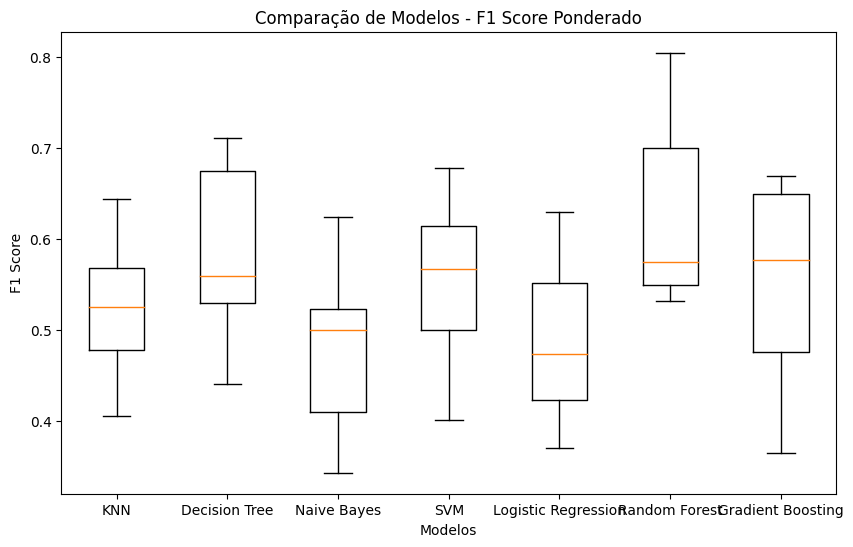

In [27]:
# Plotando os resultados dos modelos
plt.figure(figsize=(10, 6))
plt.boxplot(results, labels=names)
plt.title('Comparação de Modelos - F1 Score Ponderado')
plt.ylabel('F1 Score')
plt.xlabel('Modelos')
plt.show()

Ajustando hiperparametros

Aqui demora uns 5 minutos e meio, pode reparar que montei alguns pips e no final deixei apenas um o escolhido.

In [28]:
# Definir o pipeline para incluir o escalonamento e o modelo
pipelines = {
    # 'svm': Pipeline([
    #     ('scaler', StandardScaler()),  # Escalonamento
    #     ('svm', SVC(class_weight='balanced'))  # Modelo SVM
    # ]),
    'random_forest': Pipeline([
        ('scaler', StandardScaler()),  # Escalonamento
        ('rf', RandomForestClassifier(class_weight='balanced'))  # Adicionar balanceamento de classes
    ])
    # 'gradient_boosting': Pipeline([
    #     ('scaler', StandardScaler()),  # Escalonamento
    #     ('gb', GradientBoostingClassifier())
    # ])
}

# Definir os hiperparâmetros para cada modelo
param_grids = {
    # Removido do PIP
    # 'svm': {
    #     'svm__C': [200, 500, 1000],
    #     'svm__gamma': [1e-5, 1e-4, 1e-3, 1],
    #     'svm__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    #     'svm__degree': [2, 3, 4]
    # },
    # Parametros iniciais
    'random_forest': {
        'rf__n_estimators': [100, 300, 500],
        'rf__max_depth': [20, 30, None],
        'rf__min_samples_split': [5, 10],  # Ajustar o min_samples_split
        'rf__min_samples_leaf': [1, 2],  # Ajustar min_samples_leaf
        'rf__max_features': ['sqrt', 'log2'],  # Continuar com opções mais estáveis
        'rf__class_weight': ['balanced']  # Usar o balanceamento de classes
    }
    # Usando os parametros otimizados
    # 'random_forest': {
    #     'rf__n_estimators': [500],  # Aumentando n_estimators
    #     'rf__max_depth': [20, 30, None],  # Mantém o ajuste
    #     'rf__min_samples_split': [5, 10],  # Mantém o ajuste
    #     'rf__min_samples_leaf': [3, 4],  # Mantém o ajuste
    #     'rf__max_features': ['sqrt', 'log2'],  # Mantém o ajuste
    #     'rf__class_weight': ['balanced']  # Mantém o ajuste
    # }
    # Removido do Pip
    # 'gradient_boosting': {
    #     'gb__n_estimators': [300, 400, 500],
    #     'gb__learning_rate': [0.005, 0.01, 0.1],
    #     'gb__max_depth': [3, 4, 5, 6]
    # }
}

# Usar StratifiedKFold para manter a proporção de classes
cv = StratifiedKFold(n_splits=5)

# Iterar sobre os pipelines e realizar o GridSearchCV
for model_name in pipelines:
    print(f"Ajustando hiperparâmetros para: {model_name}")
    grid_search = GridSearchCV(pipelines[model_name], param_grids[model_name], cv=10, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_scaled, y_train)

    # Exibir os melhores parâmetros e acurácia para cada modelo
    print(f"Melhor Parâmetro para {model_name}: {grid_search.best_params_}")
    print(f"Melhor Acurácia para {model_name}: {grid_search.best_score_:.4f}")

    # Avaliar o melhor modelo no conjunto de teste
    best_model = grid_search.best_estimator_
    test_accuracy = best_model.score(X_test_scaled, y_test)
    print(f"Acurácia no conjunto de teste para {model_name}: {test_accuracy:.4f}\n")
    print(df_partidas_nao_realizadas.columns)



Ajustando hiperparâmetros para: random_forest
Fitting 10 folds for each of 72 candidates, totalling 720 fits
Melhor Parâmetro para random_forest: {'rf__class_weight': 'balanced', 'rf__max_depth': 30, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Melhor Acurácia para random_forest: 0.5308
Acurácia no conjunto de teste para random_forest: 0.4167

Index(['Rodada', 'Mandante', 'Visitante', 'Data', 'Posicao_Mandante',
       'Posicao_Visitante', 'Diferenca_Posicao'],
      dtype='object')


Aplicando o modelo em partidas não Realizadas

In [29]:
# Codificando os times nas partidas não realizadas
df_partidas_nao_realizadas['Time_Mandante_Cod'] = label_encoder.transform(df_partidas_nao_realizadas['Mandante'])
df_partidas_nao_realizadas['Time_Visitante_Cod'] = label_encoder.transform(df_partidas_nao_realizadas['Visitante'])

# Adicionando as colunas de posição para mandante e visitante
df_partidas_nao_realizadas['Posicao_Mandante_Cod'] = df_partidas_nao_realizadas['Mandante'].apply(lambda x: obter_posicao(x, df_classificacao_ultima_rodada))
df_partidas_nao_realizadas['Posicao_Visitante_Cod'] = df_partidas_nao_realizadas['Visitante'].apply(lambda x: obter_posicao(x, df_classificacao_ultima_rodada))

# Calculando a diferença de posição
df_partidas_nao_realizadas['Diferenca_Posicao'] = df_partidas_nao_realizadas['Posicao_Mandante_Cod'] - df_partidas_nao_realizadas['Posicao_Visitante_Cod']

# Definindo as variáveis independentes das novas partidas, garantindo que os nomes correspondam ao que foi usado no treinamento
X_novas_partidas = df_partidas_nao_realizadas[['Time_Mandante_Cod', 'Time_Visitante_Cod',
                                               'Posicao_Mandante_Cod', 'Posicao_Visitante_Cod',
                                               'Diferenca_Posicao']]

# Escalonando os dados das novas partidas
X_novas_partidas_scaled = scaler.transform(X_novas_partidas)

# Fazendo as predições nas novas partidas usando o modelo otimizado
predicoes = best_model.predict(X_novas_partidas_scaled)

# Adicionando as predições ao dataframe
df_partidas_nao_realizadas['Resultado_Previsto_Cod'] = predicoes
df_partidas_nao_realizadas['Resultado_Previsto'] = resultado_encoder.inverse_transform(predicoes)

# Visualizando as predições
df_partidas_nao_realizadas[['Mandante', 'Visitante', 'Resultado_Previsto']]


,Mandante,Visitante,Resultado_Previsto
0,Cuiabá,Criciúma,Empate
1,Botafogo,Fortaleza,Empate
2,Cruzeiro,Atlético-GO,Vitoria_Mandante
3,Grêmio,Atlético-MG,Vitoria_Visitante
4,Corinthians,Flamengo,Vitoria_Visitante
...,...,...,...
135,Palmeiras,Fluminense,Vitoria_Mandante
136,Bragantino,Criciúma,Empate
137,Fortaleza,Internacional,Vitoria_Mandante
138,Cuiabá,Vasco,Vitoria_Visitante


Salvando o Modelo Treinado

In [30]:
# Serializando os objetos
joblib.dump(best_model, 'modelo_treinado.pkl')
print("Modelo salvo com sucesso!", model)
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Label Encoder salvo com sucesso!", label_encoder)
joblib.dump(scaler, 'scaler.pkl')
print("Scaler salvo com sucesso!", scaler)
joblib.dump(resultado_encoder, 'resultado_encoder.pkl')
print("Resultado Encoder salvo com sucesso!", resultado_encoder)

# Download dos objetos
files.download('modelo_treinado.pkl')
files.download('label_encoder.pkl')
files.download('scaler.pkl')
files.download('resultado_encoder.pkl')

Modelo salvo com sucesso! GradientBoostingClassifier()
Label Encoder salvo com sucesso! LabelEncoder()
Scaler salvo com sucesso! StandardScaler()
Resultado Encoder salvo com sucesso! LabelEncoder()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Considerações Finais

Iniciei o trabalho sem saber exatamente os desafios que iria enfrentar, afinal ciência de dados não era a minha praia, definitivamente me apaixonei, sabia apenas que queria treinar um modelo que fosse capaz de prever Vitórias, Empates e Derrotas, mas não imaginva quais seriam as features mais importantes nessa jornada, fui explorando features, incluindo retirando recomeçando do zero, até que entendi os dados e o raciocinio, o principal pra mim é que a acuracia em casos mais complexos como esse nem sempre é alta, porém acho que consegui achar uma satisfatória treinei o modelo usando vários algoritimos e o que eu escolhi foi o random_forest, mesmo demorando cerca de 5 minutos e meio, para executar no final ele me deu um resultado que achei satisfatorio, levando em consideração a posição do clube na tabela e sua pontuação a predição ficou boa, sei que se tivesse mais tempo e experiência talvez teria alcançado um resultao melhor, mas fiquei satisfeito.